In [5]:
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from BandDeepHitSingle import BandedDeepHitSingle
from pycox.evaluation import EvalSurv

In [6]:
os.path.dirname(os.path.abspath('__file__'))

'C:\\Users\\gy501\\Desktop\\novel MTBR\\ReCircle\\AlphaAndSigma revise'

In [7]:
#设置种子
# se = random.randint(0,9999)
se = 4676
np.random.seed(se)
_ = torch.manual_seed(se)

# 保存C-index目录
save_C_index = os.path.join('result.csv')

#导入数据
dir_path = os.path.dirname(os.path.abspath('__file__'))
path = os.path.abspath(os.path.join(dir_path, 'metabric.csv'))
df_train = pd.read_csv(path, index_col=False)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

#处理数据
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

num_durations = 10
#labtrans = DeepHitSingle.label_transform(num_durations)
labtrans = BandedDeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)
# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = BandedDeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.6, duration_index=labtrans.cuts)
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
model.optimizer.set_lr(lr_finder.get_best_lr())

In [9]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False
log = model.fit(x_train, y_train, batch_size, epochs, callbacks,verbose,val_data=val)

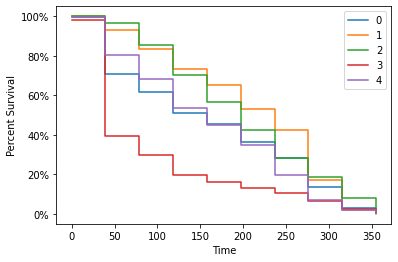

In [5]:
from matplotlib import ticker
#训练结果
surv = model.predict_surv_df(x_test)
fig = surv.iloc[:, :5].plot(drawstyle='steps-post')
config = {
    "font.family":'Arial',
    "font.size": 12,
}
plt.rcParams.update(config)
x = np.arange(1,101)
y = x/100
fig.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
plt.ylabel('Percent Survival')
_ = plt.xlabel('Time')

In [6]:
surv.iloc[:, 3]

0.000000      0.979601
39.466667     0.395178
78.933333     0.296342
118.400000    0.199543
157.866667    0.163139
197.333333    0.132263
236.800000    0.106694
276.266667    0.063324
315.733333    0.025199
355.200000    0.011268
Name: 3, dtype: float32

In [10]:
surv.iloc[:, 3].values

NameError: name 'surv' is not defined

In [9]:
bias = np.zeros(5)
bi = np.zeros(8)
for i in range(0, 5):
    for j in range(2, 8):
        bi[j] = surv.iloc[:, i].values[j-1] + surv.iloc[:, i].values[j+1] - 2 * surv.iloc[:, i].values[j]
        bias[i] += bi[j]
        # print(bias[i])
bias.round(decimals=2)

array([-0.02, -0.06,  0.  ,  0.06,  0.07])